# Investigation of the long-term CTI energy dependence for XMM-newton EPIC-pn in Large Window mode

Will investigate empirically the effect of assuming the same long-term CTI if I apply the same Cu K$\alpha$ correction curve from CCD#3 to CCD#4, where the Cu emission is only ina small part of the CCD.



In [1]:
import os
import numpy as np
import time

from astropy.io import fits
from astropy.table import Table, Column, vstack

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
home = os.path.expanduser('~')
wdir = home + "/IVAN/ccfdev"

In [2]:
def correct_energy(energy,energy_err,xtime,ccf_file,mode_id=2,rawy=190.0,verbose=True):
    #
    # correct the energy of a photon at a particular read-out node RAWY (deafult to the boresight RAWY=190)
    # with the long-term CTI, depends on time of arrival
    #
    # energy - the event energy in keV
    # xtime - the event time in years since 2000-01-01
    # ccf_file - the relevant CCF file with the T_COEFF table
    # mode_id - the mode, 0-FF, 1-eFF, 2-LW (default), 3-SW
    # rawy - the read-out node in terms of RAWY coordinate (default to 190, the boresight in CCDNR 4)
    #
    # Method:
    #    as in SAS, 1) linear interpolation in time and 2) linear interpolation in log10(energy) to find the 
    #    correction from the T_COEFF tables at the available reference energies.
    #
    if (not os.path.isfile(ccf_file)):
        print (f"CCF file {ccf_file} not found.")
        raise FileNotFoundError
    #
    hdu = fits.open(f"{ccf_file}")
    ltc = hdu['LONG_TERM_CTI']
    times = hdu['LTC_TIMES'].data["TIME"][0]
    #
    ix = np.where(ltc.data['MODE_ID'] == mode_id)[0]
    xtab = ltc.data[ix]
    i4 = np.where(xtab['CCD_ID'] == 4)[0]
    xtab4 = xtab[i4]
    # now loop over all energies
    nref = xtab4['T_COEFF'].shape[0]
    qcor = np.zeros(nref)
    xen = np.zeros(nref)
    for j in np.arange(nref):
        tcorr = xtab4['T_COEFF'][j]
        corr = np.power((1.0 - tcorr)/(1.0-tcorr[0]),rawy)
        #
        qcor[j] = np.interp(xtime,times,corr)
        xen[j] = np.log10(xtab4['ENERGY'][j])
    #
    result = np.interp(np.log10(energy),xen,qcor)
    new_energy = energy/result
    new_energy_err = energy_err/result
    if verbose:
        print (f"Photon with energy {energy} arriving at relative time {xtime} years since 2000-01-01 at RAWY {rawy}")
        print (f"Using EPN_CTI file {ccf_file}")
        print (f"===> Correction factor Eobs/Elab = {result:.5f}")
        print (f"===> New photon energy = {new_energy:.3f} +/- {new_energy_err:.3f} keV (input={energy:.3f} +/- {energy_err:.3f} keV)")
    hdu.close()
    return new_energy, new_energy_err
# 

In [13]:
def correct_energy_mod1(energy,energy_err,xtime,ccf_file,mode_id=2,rawy=190.0,verbose=True):
    #
    # correct the energy of a photon at a particular read-out node RAWY (deafult to the boresight RAWY=190)
    # with the long-term CTI, depends on time of arrival
    #
    # energy - the event energy in keV
    # xtime - the event time in years since 2000-01-01
    # ccf_file - the relevant CCF file with the T_COEFF table
    # mode_id - the mode, 0-FF, 1-eFF, 2-LW (default), 3-SW
    # rawy - the read-out node in terms of RAWY coordinate (default to 190, the boresight in CCDNR 4)
    #
    # Method:
    #    as in SAS, 1) linear interpolation in time and 2) linear interpolation in log10(energy) to find the 
    #    correction from the T_COEFF tables at the available reference energies.
    #
    # mod1 version will not use the Mn Ka line, but only Al Ka (1.5 keV) and Cu Ka (8.04) from CCD#3
    #
    if (not os.path.isfile(ccf_file)):
        print (f"CCF file {ccf_file} not found.")
        raise FileNotFoundError
    #
    hdu = fits.open(f"{ccf_file}")
    ltc = hdu['LONG_TERM_CTI']
    times = hdu['LTC_TIMES'].data["TIME"][0]
    #
    ix = np.where(ltc.data['MODE_ID'] == mode_id)[0]
    xtab = ltc.data[ix]
    i4 = np.where(xtab['CCD_ID'] == 4)[0]
    xtab4 = xtab[i4]
    # the curve for CCD#3
    i3 = np.where(xtab['CCD_ID'] == 3)[0]
    xtab3 = xtab[i3]
    # now loop over all energies
    nref = xtab4['T_COEFF'].shape[0]
    qcor = np.zeros(nref)
    xen = np.zeros(nref)
    for j in np.arange(nref):
        xen[j] = np.log10(xtab4['ENERGY'][j])
        tcorr = xtab4['T_COEFF'][j]
        if (xen[j] > np.log10(8.0)):
            tcorr = xtab3['T_COEFF'][j]
        corr = np.power((1.0 - tcorr)/(1.0-tcorr[0]),rawy)
        #
        qcor[j] = np.interp(xtime,times,corr)
    #
    # now interpolate without the mid-point (Mn Ka)
    inxx = [0,2]
    result = np.interp(np.log10(energy),xen[inxx],qcor[inxx])
    new_energy = energy/result
    new_energy_err = energy_err/result
    if verbose:
        print (f"Photon with energy {energy} arriving at relative time {xtime} years since 2000-01-01 at RAWY {rawy}")
        print (f"Using EPN_CTI file {ccf_file}")
        print (f"===> Correction factor Eobs/Elab = {result:.5f}")
        print (f"===> New photon energy = {new_energy:.3f} +/- {new_energy_err:.3f} keV (input={energy:.3f} +/- {energy_err:.3f} keV)")
    hdu.close()
    return new_energy, new_energy_err
# 

In [5]:
def correct_energy_bore_mod(energy,energy_err,xtime,ccf_file,mode_id=2,verbose=True):
    #
    # correct the energy of a photon at the boresight with the long-term CTI, depends on time
    #
    # energy - the event energy in keV
    # xtime - the event time in years since 2000-01-01
    # ccf_file - the relevant CCF file with the T_COEFF table
    # mode_id - the mode, 0-FF, 1-eFF, 2-LW, 3-SW
    #
    #
    # MODIFIED: usig the derived Cu Ka from CCD#3 instead the one for CCD#4, because Cu is not 
    # very strong around the boresight
    #
    if (not os.path.isfile(ccf_file)):
        print (f"CCF file {ccf_file} not found.")
        raise FileNotFoundError
    #
    hdu = fits.open(f"{ccf_file}")
    ltc = hdu['LONG_TERM_CTI']
    times = hdu['LTC_TIMES'].data["TIME"][0]
    #
    ix = np.where(ltc.data['MODE_ID'] == mode_id)[0]
    xtab = ltc.data[ix]
    i4 = np.where(xtab['CCD_ID'] == 4)[0]
    xtab4 = xtab[i4]
    i3 = np.where(xtab['CCD_ID'] == 3)[0]
    xtab3 = xtab[i3]
    # now loop over all energies
    nref = xtab4['T_COEFF'].shape[0]
    qcor = np.zeros(nref)
    xen = np.zeros(nref)
    for j in np.arange(nref):
        xen[j] = np.log10(xtab4['ENERGY'][j])
        tcorr = xtab4['T_COEFF'][j]
        # use the correction for CCD#3 for energy 8.04
        if (xen[j] > np.log10(8.0)):
            tcorr = xtab3['T_COEFF'][j]
        corr = np.power((1.0 - tcorr)/(1.0-tcorr[0]),190.0)
        #
        qcor[j] = np.interp(xtime,times,corr)
    #
    result = np.interp(np.log10(energy),xen,qcor)
    new_energy = energy/result
    new_energy_err = energy_err/result
    if verbose:
        print (f"MOD Correction factor Eobs/Elab = {result:.5f}")
        print (f"MOD New photon energy = {new_energy:.3f} +/- {new_energy_err:.3f} keV (input={energy:.3f} +/- {energy_err:.3f} keV)")
    hdu.close()
    return new_energy, new_energy_err
# 

In [6]:
today = time.strftime("%c")
#
ccfdir = '/ccf/pub'
#ccf_file = f"{ccfdir}/EPN_CTI_0049.CCF"
ccf_file = f"{ccfdir}/EPN_CTI_0050.CCF"
hdu = fits.open(f"{ccf_file}")
ltc = hdu['LONG_TERM_CTI']
times = hdu['LTC_TIMES'].data["TIME"][0]

In [14]:
correct_energy_mod1(6.4,0.01,10.0,ccf_file)

Photon with energy 6.4 arriving at relative time 10.0 years since 2000-01-01 at RAWY 190.0
Using EPN_CTI file /ccf/pub/EPN_CTI_0050.CCF
===> Correction factor Eobs/Elab = 0.98315
===> New photon energy = 6.510 +/- 0.010 keV (input=6.400 +/- 0.010 keV)


(6.509717398453832, 0.010171433435084112)

## PN long-term CTI in Large Window Mode

Will read the correction coefficients for CCD#3 and interpolate to get the value at 6.4 keV

In [26]:
#
mode_id = 2 # Large Window mode
ix = np.where(ltc.data['MODE_ID'] == mode_id)[0]
xtab = ltc.data[ix]
i3 = np.where(xtab['CCD_ID'] == 3)[0]
xtab3 = xtab[i3]
#
i4 = np.where(xtab['CCD_ID'] == 4)[0]
xtab4 = xtab[i4]
#
log_e1 = np.log10(1.486)
log_e5 = np.log10(5.8988)
log_e64 = np.log10(6.4)
log_e8 = np.log10(8.04)
#
tc1 = xtab4['T_COEFF'][0]
tc5 = xtab4['T_COEFF'][1]
tc8 = xtab4['T_COEFF'][2]
tc8_3 = xtab3['T_COEFF'][2]
#
qc1 = np.power((1.0 - tc1)/(1.0-tc1[0]),190.0)
qc5 = np.power((1.0 - tc5)/(1.0-tc5[0]),190.0)
qc8 = np.power((1.0 - tc8)/(1.0-tc8[0]),190.0)
qc8_3 = np.power((1.0 - tc8_3)/(1.0-tc8_3[0]),190.0)
#
nt = len(qc5)
outy = np.zeros(nt)
outy4 = np.zeros(nt)
outy1 = np.zeros(nt)
#
xp = [log_e5,log_e8]
for i in np.arange(nt):
    yp = [qc5[i],qc8[i]]
    yp1 = [qc1[i],qc8_3[i]]
    yp4 = [qc5[i],qc8_3[i]]
    outy[i] = np.interp(log_e64,xp,yp)
    outy4[i] = np.interp(log_e64,xp,yp4)
    outy1[i] = np.interp(log_e64,xp,yp1)
    #

## Read the AGN no CTI results


In [27]:
#
# define the targets and their redshift
#
targets = ["ngc3227","mkn1040","mkn915","ngc6814",'mkn883','tycho', 'ngc5899','ngc526a']
colors = {"ngc3227":'red',"mkn1040":'green',"mkn915":'blue',"ngc6814":'magenta','mkn883':'cyan','tycho': 'brown',
         'ngc5899': 'lime', 'ngc526a': 'orange'}
#
# redshifts
#
redshift = {'ngc4151': 0.003262, 'ngc3227': 0.00386, 'mrk1048': 0.0427, 'ngc3783': 0.009755,\
            'ngc4593': 0.008344, 'ngc5506': 0.00589, 'mcg-5-23-16': 0.008226, 'ngc3516': 0.008816,\
            'ngc5548': 0.01627, 'ngc2992':  0.007296, 'ngc1566': 0.005036, 'iras09149': 0.057150,\
            "iras05078": 0.017879, 'ngc7213': 0.005869,"mkn915": 0.024043,"mkn1040":0.016338,\
            "ngc6814": 0.005227, 'mkn883': 0.03787, 'tycho': 0.0, 'ngc5899': 0.00880, 'ngc526a': 0.01897}
feK = 6.399 # the weighted mean of Fe Kalpha_2 at 6.3908 (intensity 50) and Fe Kalpha_1 at 6.40308 (intensity 100)

In [28]:
#
# calculate the differences and plot
# save some info in a tex table
#
xratio = []
xratio_err = []
xrtime = []
newlines = []
newlines_err = []
xnewlines = []
xnewlines_err = []
vers = "nocti"
k = 0
wdir = "/xdata/xcaldata/XMM/IVAN/PN_LW/sources"
for target in targets:
    print (f"Adding {target}")
    # skip Mkn883
    if (target == 'mkn883'):
        continue
    out_tab = f'{wdir}/{target}_xspec_output_{vers}.csv'
    if (not os.path.isfile(out_tab)):
        print (f"No {vers} results found for target {target}: {out_tab}")
        continue
    t = Table.read(out_tab,data_start=0,names=("obsid","expo","rev","delta_time","submode",\
                                  "xfilt","inst","ontime",\
                                  "lineE","lineE_err","lineE_err2","cstat","chi2r","dof"))
    nt = len(t)
    #
    lineX =  feK/(1.0 + redshift[target]) # redshifted line position
    for ij in np.arange(nt):
        rev = t['rev'].data[ij]
        rtime = t['delta_time'].data[ij]
        xrtime.append(rtime)
        line = t['lineE'].data[ij]
        lineErr = t['lineE_err2'].data[ij] # use the fit error (single parameter)
        xratio.append(line/lineX)
        xratio_err.append(lineErr/lineX)
        newl,newl_err = correct_energy(line,lineErr,rtime,ccf_file,verbose=False)
        newlines.append(1000*(newl-lineX))
        newlines_err.append(1000*(newl_err))
        newl,newl_err = correct_energy_mod1(line,lineErr,rtime,ccf_file,verbose=False)
        xnewlines.append(1000*(newl-lineX))
        xnewlines_err.append(1000*(newl_err))
#
xrtime = np.asarray(xrtime)
newlines = np.asarray(newlines)
newlines_err = np.asarray(newlines_err)
xnewlines = np.asarray(xnewlines)
xnewlines_err = np.asarray(xnewlines_err)
#

Adding ngc3227
Adding mkn1040
Adding mkn915
Adding ngc6814
Adding mkn883
Adding tycho
Adding ngc5899
Adding ngc526a


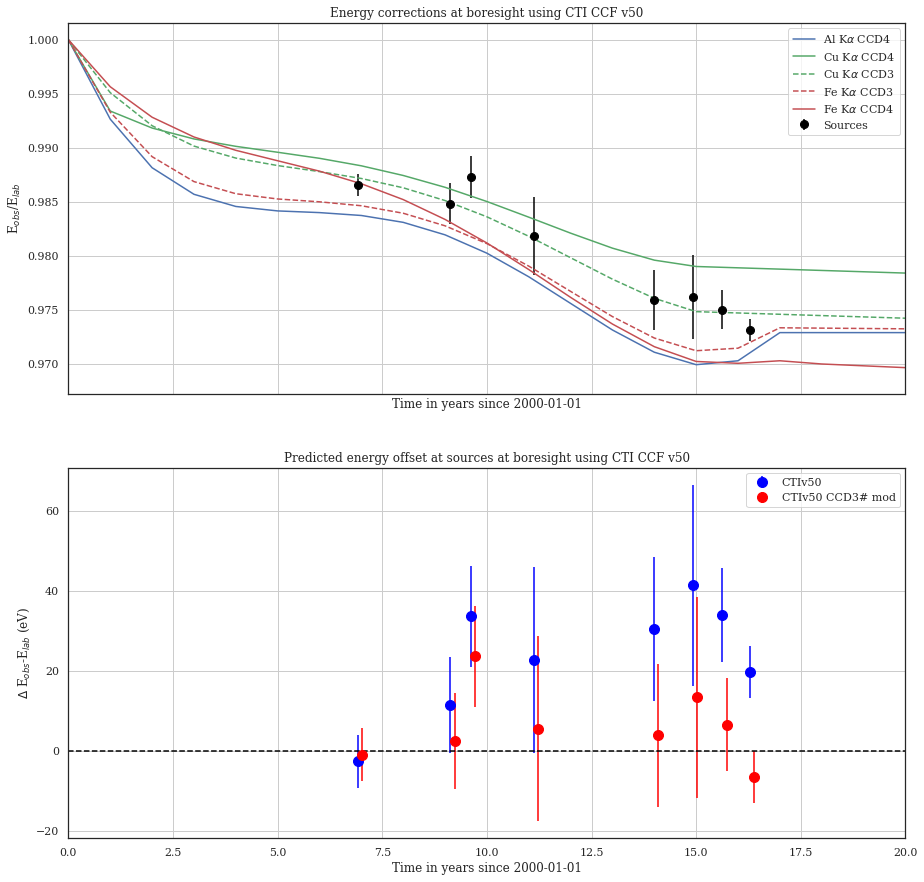

In [29]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))
#uncrt = 0.01 # 5% uncertainty on values
#ax[0].plot(times,qc5,'b-',label=r'Mn K$\alpha$ CCD3')
ax[0].plot(times,qc1,'b-',label=r'Al K$\alpha$ CCD4')
#ax[0].plot(times,qc5,'b-',label=r'Mn K$\alpha$ CCD4')
ax[0].plot(times,qc8,'g-',label=r'Cu K$\alpha$ CCD4')
ax[0].plot(times,qc8_3,'g--',label=r'Cu K$\alpha$ CCD3')
ax[0].plot(times,outy1,'r--',label=r'Fe K$\alpha$ CCD3')
#ax[0].plot(times,outy,'r--',label=r'Fe K$\alpha$ CCD3')
ax[0].plot(times,outy4,'r-',label=r'Fe K$\alpha$ CCD4')
#
ax[0].errorbar(xrtime,xratio,yerr=xratio_err,fmt='o',color='black',ms=8,label="Sources")
#
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel("Time in years since 2000-01-01")
ax[0].set_ylabel(r"E$_{obs}$/E$_{lab}$")
ax[0].set_xlim((0.0,20))
ax[0].set_title("Energy corrections at boresight using CTI CCF v50");
#ax[1].plot(times,1000*zcor4,'o-')
ax[1].errorbar(xrtime,newlines,yerr=newlines_err,fmt='o',ms=10,color='blue',label='CTIv50')
ax[1].errorbar(xrtime+0.1,xnewlines,yerr=xnewlines_err,fmt='o',ms=10,color='red',label='CTIv50 CCD3# mod')
ax[1].axhline(0.0,linestyle='dashed',color='black')
ax[1].set_xlabel("Time in years since 2000-01-01")
ax[1].set_ylabel(r'$\Delta$ E$_{obs}$-E$_{lab}$ (eV)')
ax[1].grid();
ax[1].legend();
ax[1].set_title("Predicted energy offset at sources at boresight using CTI CCF v50");
#
plt.savefig(f'{wdir}/cuka_alka_tests_sources_ccd3.png',dpi=100)
plt.show()
plt.close();

## PN long-term CTI in Full Frame Mode